In [93]:
import pandas as pd
import altair as alt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [94]:
# load data, note that these data are the same as used in the EDA just with columns removed to be in similar format
# to that from what the app will load
boardgame_data_raw = pd.read_csv("board_game_tsne.csv")
boardgame_data = boardgame_data_raw.copy()
boardgame_data["year_published"] = pd.to_datetime(boardgame_data["year_published"], format="%Y")

In [95]:
boardgame_data.head()

,game_id,max_players,max_playtime,min_age,min_players,min_playtime,name,playing_time,year_published,category,compilation,designer,expansion,mechanic,publisher,average_rating,users_rated
0,1,5,240,14,3,240,Die Macher,240,1986-01-01,"Economic,Negotiation,Political",NaN,Karl-Heinz Schmiel,NaN,"Area Control / Area Influence,Auction/Bidding,...","Hans im Glück Verlags-GmbH,Moskito Spiele,Vall...",7.66508,4498
1,2,4,30,12,3,30,Dragonmaster,30,1981-01-01,"Card Game,Fantasy",NaN,"G. W. ""Jerry"" D'Arcey",NaN,Trick-taking,"E.S. Lowe,Milton Bradley",6.60815,478
2,3,4,60,10,2,30,Samurai,60,1998-01-01,"Abstract Strategy,Medieval",NaN,Reiner Knizia,NaN,"Area Control / Area Influence,Hand Management,...","999 Games,ABACUSSPIELE,Astrel Games,Ceilikan J...",7.44119,12019
3,4,4,60,12,2,60,Tal der Könige,60,1992-01-01,Ancient,NaN,Christian Beierer,NaN,"Action Point Allowance System,Area Control / A...",KOSMOS,6.60675,314
4,5,6,90,12,3,90,Acquire,90,1964-01-01,Economic,NaN,Sid Sackson,NaN,"Hand Management,Stock Holding,Tile Placement","3M,Avalon Hill,Avalon Hill (Hasbro),Dujardin,G...",7.35830,15195


In [96]:
# convert NA values for these features to a value
values = {"category": "Unknown", "mechanic": "Unknown", "publisher": "Unknown"}
boardgame_data.fillna(value=values, inplace=True)
# create lists from strings
cats_split = ["category", "mechanic", "publisher"]
boardgame_data[cats_split] = (boardgame_data[cats_split].stack().str.split(r",(?![+ ])").unstack())

In [97]:
boardgame_data.head()

,game_id,max_players,max_playtime,min_age,min_players,min_playtime,name,playing_time,year_published,category,compilation,designer,expansion,mechanic,publisher,average_rating,users_rated
0,1,5,240,14,3,240,Die Macher,240,1986-01-01,"[Economic, Negotiation, Political]",NaN,Karl-Heinz Schmiel,NaN,"[Area Control / Area Influence, Auction/Biddin...","[Hans im Glück Verlags-GmbH, Moskito Spiele, V...",7.66508,4498
1,2,4,30,12,3,30,Dragonmaster,30,1981-01-01,"[Card Game, Fantasy]",NaN,"G. W. ""Jerry"" D'Arcey",NaN,[Trick-taking],"[E.S. Lowe, Milton Bradley]",6.60815,478
2,3,4,60,10,2,30,Samurai,60,1998-01-01,"[Abstract Strategy, Medieval]",NaN,Reiner Knizia,NaN,"[Area Control / Area Influence, Hand Managemen...","[999 Games, ABACUSSPIELE, Astrel Games, Ceilik...",7.44119,12019
3,4,4,60,12,2,60,Tal der Könige,60,1992-01-01,[Ancient],NaN,Christian Beierer,NaN,"[Action Point Allowance System, Area Control /...",[KOSMOS],6.60675,314
4,5,6,90,12,3,90,Acquire,90,1964-01-01,[Economic],NaN,Sid Sackson,NaN,"[Hand Management, Stock Holding, Tile Placement]","[3M, Avalon Hill, Avalon Hill (Hasbro), Dujard...",7.35830,15195


In [98]:
# create subset of data features
boardgame_data_sub = boardgame_data.copy()
boardgame_data_sub = boardgame_data_sub[['game_id', 'name', 'category', 'compilation', 'expansion', 
                                         'mechanic', 'average_rating', 'users_rated']]

# these feastures may be added in later (all numeric)
                                        # 'max_players', 'max_playtime', 'min_age', 'min_players', 
                                        # 'min_playtime', 'playing_time']]

In [99]:
boardgame_data_sub.head()

,game_id,name,category,compilation,expansion,mechanic,average_rating,users_rated
0,1,Die Macher,"[Economic, Negotiation, Political]",NaN,NaN,"[Area Control / Area Influence, Auction/Biddin...",7.66508,4498
1,2,Dragonmaster,"[Card Game, Fantasy]",NaN,NaN,[Trick-taking],6.60815,478
2,3,Samurai,"[Abstract Strategy, Medieval]",NaN,NaN,"[Area Control / Area Influence, Hand Managemen...",7.44119,12019
3,4,Tal der Könige,[Ancient],NaN,NaN,"[Action Point Allowance System, Area Control /...",6.60675,314
4,5,Acquire,[Economic],NaN,NaN,"[Hand Management, Stock Holding, Tile Placement]",7.35830,15195


In [100]:
# compilation and expansion have a high number of values and many boardgames don't have any values at all
# just list whether a game is part of a compilation or expanionsion or not (1, 0) encoding
boardgame_data_sub[['expansion', 'compilation']] = boardgame_data_sub[['expansion', 'compilation']].notna().astype(int)

In [101]:
# check that dataset is complete
boardgame_data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532 entries, 0 to 10531
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   game_id         10532 non-null  int64  
 1   name            10532 non-null  object 
 2   category        10532 non-null  object 
 3   compilation     10532 non-null  int32  
 4   expansion       10532 non-null  int32  
 5   mechanic        10532 non-null  object 
 6   average_rating  10532 non-null  float64
 7   users_rated     10532 non-null  int64  
dtypes: float64(1), int32(2), int64(2), object(3)
memory usage: 576.1+ KB


In [102]:
# convert category and mechanic to one hot encoding and standardize the columns
# standardizing resulted in a better tsne result
binarizer = MultiLabelBinarizer()
category = pd.DataFrame(scale(binarizer.fit_transform(boardgame_data_sub.category)), columns = binarizer.classes_)
binarizer = MultiLabelBinarizer()
mechanic = pd.DataFrame(scale(binarizer.fit_transform(boardgame_data_sub.mechanic)), columns = binarizer.classes_)

onehot_df = pd.concat([category, mechanic], axis = 1)
onehot_df

# numeric user rating categories (it was found that not standardizing creates a better tsne result for this axis)
user_scaled = pd.DataFrame(boardgame_data_sub[['average_rating', 'users_rated']], columns = ['average_rating', 'users_rated'])

In [103]:
# run T-SNE on one-hot encoded category and mechanic features
# a high perplexity was found to provide a good visual result
tsne_cat = TSNE(perplexity=50, n_components=2)
tsne_cat_results = tsne_cat.fit_transform(onehot_df)
# run TSNE on user ratings features
# this is done as we want a separate axis related to user rating
tsne_user  = TSNE(perplexity=50, n_components=1)
tsne_user_results = tsne_user.fit_transform(user_scaled)

In [107]:
# create a dataframe for output
tsne_cat_df = pd.DataFrame(tsne_cat_results, columns=["x", "y"])
# note: dividing user tsne results by 2 for plotting purposes
tsne_user_df = pd.DataFrame((tsne_user_results * -1) / 2, columns=["z"])
combined_output = pd.concat([boardgame_data, tsne_cat_df, tsne_user_df], axis=1)

In [108]:
# labeller helper for categories for checking visualization
def highlighter(x, labels):
    for label in labels:
        if (label in x): return label
    return 'none'

In [109]:
combined_output['highlight'] = combined_output.category.map(lambda x: highlighter(x, ['Economic', 'Vietnam War', 'Farming', 'Nautical']))

In [110]:
combined_output.highlight.unique()

array(['Economic', 'none', 'Nautical', 'Farming', 'Vietnam War'],
      dtype=object)

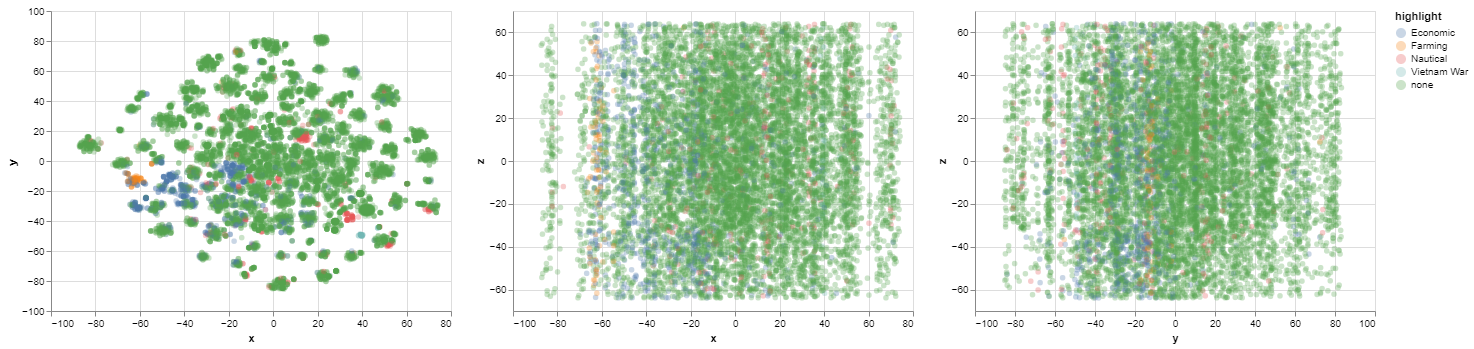

In [111]:
first = (alt.Chart(combined_output).mark_circle(opacity=0.3).encode(
    alt.X('x'),
    alt.Y('y'),
    alt.Color('highlight')))

second = (alt.Chart(combined_output).mark_circle(opacity=0.3).encode(
    alt.X('x'),
    alt.Y('z'),
    alt.Color('highlight')))

third = (alt.Chart(combined_output).mark_circle(opacity=0.3).encode(
    alt.X('y'),
    alt.Y('z'),
    alt.Color('highlight')))

first | second | third

In [112]:
combined_output_save = pd.concat([boardgame_data_raw, tsne_cat_df, tsne_user_df], axis=1)
combined_output_save.to_csv('board_game_tsne_processed.csv', index=False)